# Random Walks about London


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%reload_ext autoreload

## Graphical Data Sources

You can easily retrieve a graph (NetworkX) representation of London locality using the `osmnx` library. Say that you're only looking to walk a short distance, say < 1 km. You can use the `graph_from_point`.

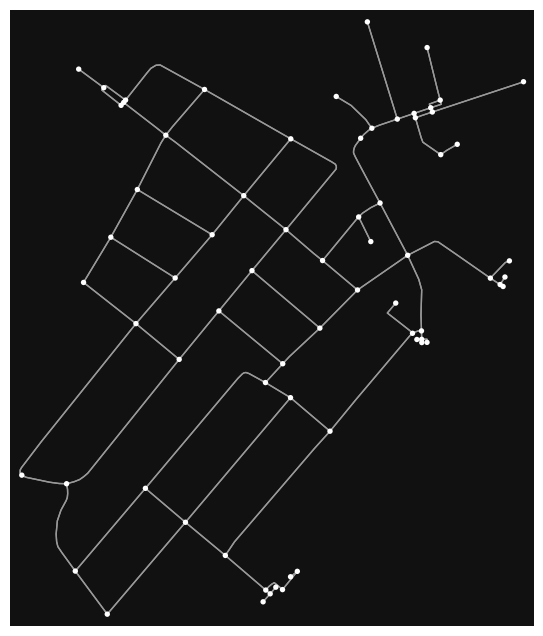

In [1]:
import osmnx as ox
from web_map import open_google_maps
START = (51.564, 0.00227) # (latitude, longitude), not my real address

G = ox.graph.graph_from_point(START, network_type="walk", dist=500, dist_type="network")

fig, ax = ox.plot_graph(G)
open_google_maps(START, open_in='inline')

For larger examples, like the size of Greater London, Pyrosm is recommended. I would recommend locally downloading the OSM data through [this Geofabrik link](https://download.geofabrik.de/europe/united-kingdom/england/greater-london-latest.osm.pbfa) for instance.

In [3]:
from pyrosm import OSM
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="pyrosm")

START = (51.564, 0.00227)

USE_COLUMNS = ["id",
               "name",
               "timestamp",
               "version",
               "tags",
               "osm_type",
               "geometry",
               "u",
               "v",
               "length"]

bbox = [-0.3, 51.4, 0.2, 51.65]
osm_parser = OSM("data/greater-london-260126.osm.pbf", bounding_box=bbox)

gdf_nodes, gdf = osm_parser.get_network(network_type="walking", nodes=True)
gdf = gdf[USE_COLUMNS]

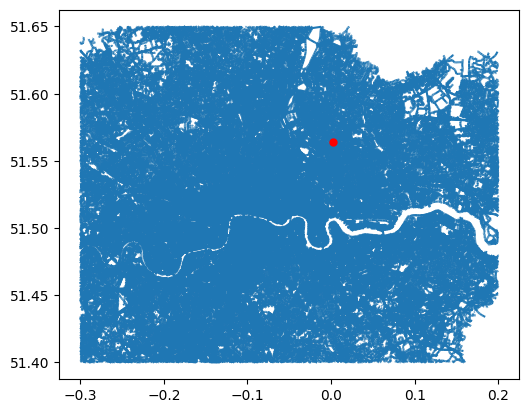

In [4]:
gdf.plot()
# gdf_nodes.plot(color='k')
plt.plot(START[1], START[0], marker="o", color="red", markersize=5);

## Measures of distance

There's motivation to approximate the earth as spherical for approximating geodesic distances using numpy arrays for speed on this scale - London isn't hilly, and variation in effective spherical radius with latitude will be << 0.1% across London. For the sake of finding the nearest node, we need only use that the geodesic distance proportional to the haversine distance.

In [9]:
from distances import get_nearest_node_uid, numpy_geodesic_distance

pt = START
nearest_node_uid, nearest_node_row_id = get_nearest_node_uid(gdf_nodes, pt, return_row_id=True)
nearest_node_coords = gdf_nodes[gdf_nodes['id'] == nearest_node_uid][['lat', 'lon']].values[0]
distances = numpy_geodesic_distance(gdf_nodes[['lat', 'lon']].values, pt)
print("Nearest node UID:", nearest_node_uid)
print("Nearest node row ID:", nearest_node_row_id)
print(f"Nearest node coordinates (lat, lon): {nearest_node_coords[0]:.5f}, {nearest_node_coords[1]:.5f}")
print(f"Distance to nearest node (m): {distances[nearest_node_row_id]:.1f}")

Nearest node UID: 8318922803
Nearest node row ID: 931181
Nearest node coordinates (lat, lon): 51.56368, 0.00198
Distance to nearest node (m): 40.7


In [ ]:
# TODOs
# TODO: Are all the points correctly ordered?
# TODO: Try to iteratively fit alpha, beta and the max/scale manually
# TODO: Comparelengths to geodesic distances
# TODO: Write random walker to output a list of (directed) edges

In [6]:
u_coords = gdf.geometry.boundary.get_geometry(0).get_coordinates().values
v_coords = gdf.geometry.boundary.get_geometry(1).get_coordinates().values

coordinate_distances = numpy_geodesic_distance(u_coords, v_coords)

How do these distances compare with the given lengths? There is a predictable deviation, and some evidence of discretisation, but roughly 
$$ d_{geodesic} = e^{\beta}d_{length} $$
for some roughly scaled-beta distributed r.v. $\beta$, where roughly speaking $0 \leq \beta \leq 0.5$

c:\Users\Jacob\miniconda3\envs\londonwalk\Lib\site-packages\geopandas\geodataframe.py:1969: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


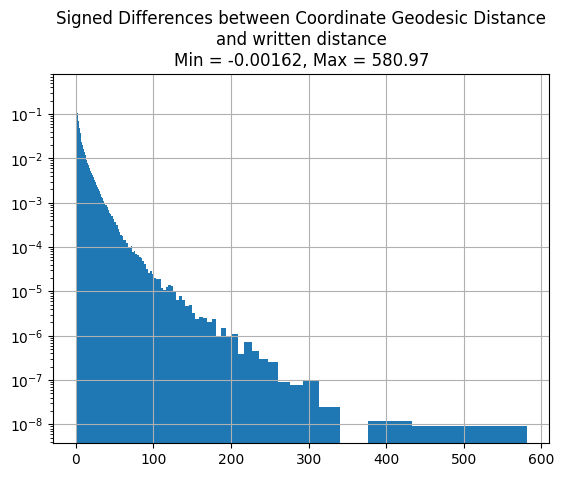

In [7]:
import numpy as np

gdf_no_loops = gdf[~(gdf.geometry.boundary.is_empty)]
gdf_no_loops['coordinate_distance'] = coordinate_distances
differences = (coordinate_distances - gdf_no_loops['length'])
min_diff = differences.min()
max_diff = differences.max()
LOG_BASE = 0.99
bins = np.emath.logn(LOG_BASE, np.linspace(LOG_BASE**min_diff, LOG_BASE**max_diff, 101))
differences.hist(bins=bins, log=True, density=True)
plt.title(f"Signed Differences between Coordinate Geodesic Distance\nand written distance\nMin = {min_diff:.5f}, Max = {max_diff:.2f}");

In [ ]:
from web_map import open_google_maps_from_geodf

large_deviations = gdf_no_loops[differences > 300]
large_deviation_nodes = gdf_nodes.merge(large_deviations[['u']], how='inner', right_on='u', left_on='id')
open_google_maps_from_geodf(large_deviation_nodes)

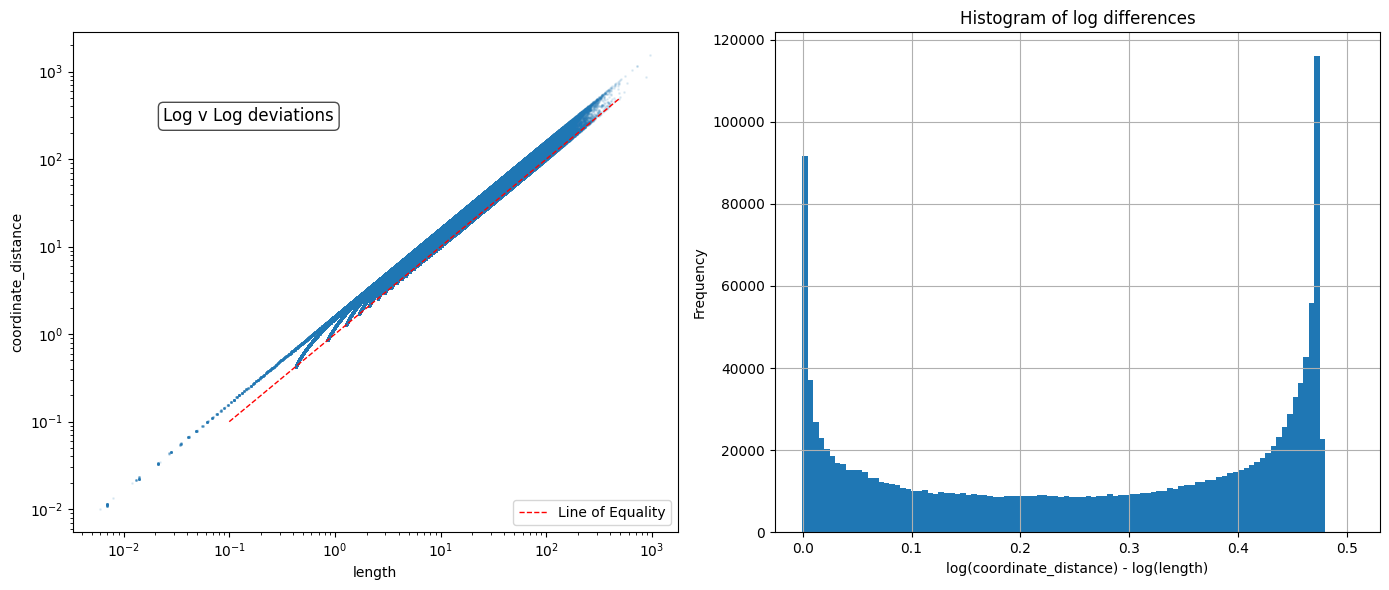

In [9]:
import numpy as np

LABEL_TEXT = """Log v Log deviations"""

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# First plot: scatter log-log
ax1 = axes[0]
gdf_no_loops.plot(kind='scatter', x='length', y='coordinate_distance', s=1, alpha=0.1, ax=ax1)
ax1.plot([0.1, 500], [0.1, 500], linestyle='--', color='red', linewidth=1, label='Line of Equality')
ax1.text(0.15, 0.85, LABEL_TEXT, transform=ax1.transAxes, fontsize=12, verticalalignment='top', bbox=dict(boxstyle="round", facecolor="white", alpha=0.7))
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel('length')
ax1.set_ylabel('coordinate_distance')
ax1.legend(loc='lower right')

# Second plot: histogram of log differences
ax2 = axes[1]
(np.log(coordinate_distances) - np.log(gdf_no_loops['length'])).hist(bins=101, ax=ax2)
ax2.set_title('Histogram of log differences')
ax2.set_xlabel('log(coordinate_distance) - log(length)')
ax2.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

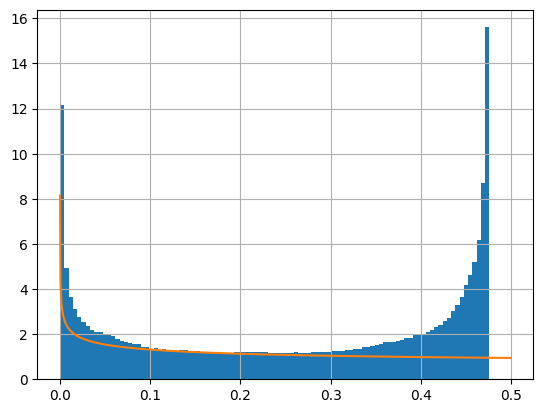

In [10]:
## Attempt to fit to a beta unsucessful

log_diffs = (np.log(coordinate_distances) - np.log(gdf_no_loops['length']))

# For fitting a beta, trim some outliers on either end.
log_diffs = log_diffs[(log_diffs > np.quantile(log_diffs, 0.005)) & (log_diffs < np.quantile(log_diffs, 0.995))]
log_diffs_min = log_diffs.min()
log_diffs_max = log_diffs.max()

from scipy.stats import beta

beta_data = ((log_diffs - log_diffs_min)*((1-log_diffs_min)/log_diffs_max))
α, β, _, sc = beta.fit(beta_data)
model = lambda d: beta.pdf(d*(log_diffs_max/1-log_diffs_min) + log_diffs_min, α, β)

log_diffs.hist(bins=101, density=True)
mesh = np.linspace(0,0.5,1001)
plt.plot(mesh, [model(x) for x in mesh])

Text(0, 0.5, 'log(coordinate_distance) - log(length)')

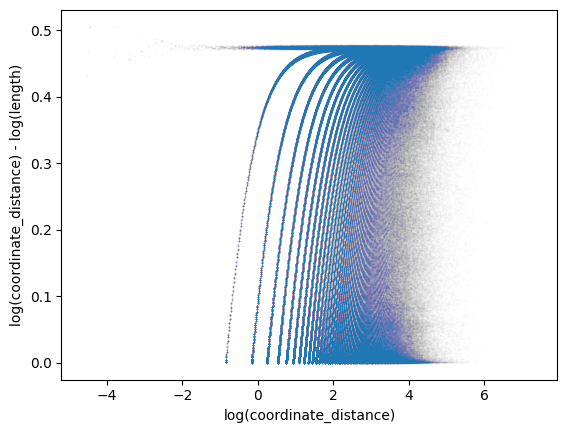

In [11]:
log_diffs = (np.log(coordinate_distances) - np.log(gdf_no_loops['length']))

plt.scatter(np.log(coordinate_distances), log_diffs, alpha=0.005, s=0.5);
plt.xlabel('log(coordinate_distance)')
plt.ylabel('log(coordinate_distance) - log(length)')

Text(0, 0.5, 'log(coordinate_distance) - log(length)')

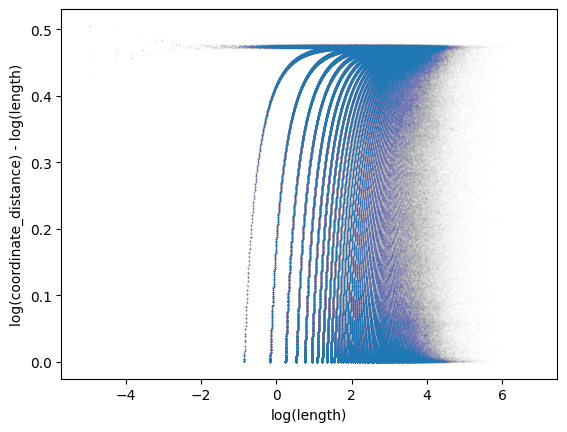

In [12]:
log_diffs = (np.log(coordinate_distances) - np.log(gdf_no_loops['length']))

plt.scatter(np.log(gdf_no_loops['length']), log_diffs, alpha=0.005, s=0.5);
plt.xlabel('log(length)')
plt.ylabel('log(coordinate_distance) - log(length)')

## Graph representation and walks

For such a graph size as much-of Greater London, NetworkX is not recommended. I will be using iGraph:
- G: iGraph - The main graph object
- walk_gid: List - Ordered list of the walk vertices, in terms of the natural indeces of G
- walk_uid: List - The same walk, but in the node uids (the 'id' column of the nodes gdf)

In [ ]:
G = osm_parser.to_graph(gdf_nodes, gdf, edge_id_col='id', node_id_col='id', force_bidirectional=True) # 'id' is needed as a column for to_graph

c:\Users\Jacob\miniconda3\envs\londonwalk\Lib\site-packages\pyrosm\graphs.py:251: UserWarning: Column 'oneway' missing in the edges GeoDataFrame. Assuming all edges to be bidirectional (travel allowed to both directions).
  nodes, edges = get_directed_edges(


In [ ]:
import igraph as ig
import random
from distances import get_nearest_node_uid
from typing import Union, Tuple, List
from shapely import Point
import geopandas as gpd
import numpy as np

def random_walk_with_restart(g: ig.Graph, start: Union[int, Tuple, Point], distance: float, nodes_df=None):
    """Generates a walk across the graph in graph-id labelled vertices and edges"""
    if isinstance(start, Point):
        start = list(start.coords._coords[0])
    if isinstance(start, (Tuple, List)):
        assert len(start) == 2, f"Expected Tuples/Lists to be a pair of (lat, lon)\nGot length{len(start)}, {start}"
        assert isinstance(nodes_df, gpd.GeoDataFrame), "nodes_df needs to be specified as a GeoDataFrame"
        start = get_nearest_node_uid(nodes_df, point=start, return_row_id=False)[0]
    start = int(start)
    start = G.vs.find(id=start)['node_id']
    walk = [start]
    v = start
    cumulative_dist = 0

    while cumulative_dist < distance:
        nbrs = g.neighbors(v)
        if not nbrs:
            break
        choice = random.choice(nbrs)
        edge = g.get_eid(v, choice)
        cumulative_dist += g.es[edge]['length']
        v = choice
        walk.append(v)

    return walk

# Walk?

walk_gid = random_walk_with_restart(G, start=START, distance=5_000_000, nodes_df=gdf_nodes)
walk_uid = [G.vs[gid]['id'] for gid in walk_gid]

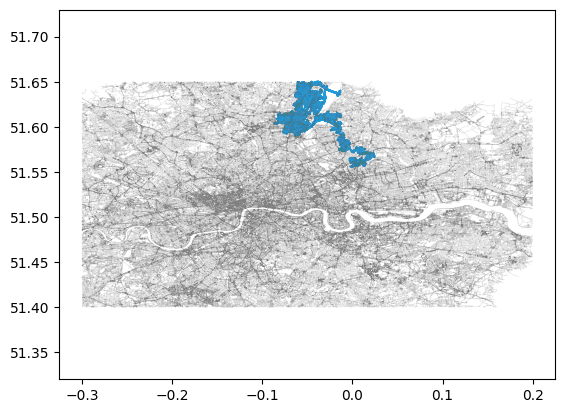

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# nodes/edges induced by the walk (node-induced)
gdf_walk_nodes = gdf_nodes[gdf_nodes['id'].isin(walk_uid)]

# Walk edges
uv_df = pd.DataFrame(np.stack([walk_uid[:-1], walk_uid[1:]]).T, columns=['u','v'])
gdf_bi = pd.concat([gdf, gdf.rename(columns={'u':'v', 'v':'u'})], ignore_index=True) #gdf is directed by default
gdf_walk_edges = gdf_bi.merge(uv_df, how='inner', on=['u','v'])

ax = gdf_walk_edges.plot(color="#189EE1")
# gdf_walk_nodes.plot(ax=ax, color="#e34a33")
gdf.plot(ax=ax, linewidth=0.5, alpha=0.2, color='gray')
plt.axis("equal")
plt.show()
